# 配置基础环境

In [147]:
import akshare as ak
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'STKAITI'
plt.rcParams['axes.unicode_minus'] = False
# 关闭警告信息
import warnings
warnings.filterwarnings('ignore')

In [155]:
# 获取上证指数数据
index_code = 'sh000001'
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2024-12-31')
price_df = ak.stock_zh_index_daily(symbol=index_code)
price_df['date'] = pd.to_datetime(price_df['date'])
price_df = price_df[(price_df['date'] >= start_date) & (price_df['date'] <= end_date)]
price_df = price_df.sort_values('date').set_index('date')

In [156]:
# 计算每日收益率
price_df['returns'] = price_df['close'].pct_change().shift(-1).fillna(0)
price_df

,open,high,low,close,volume,returns
date,,,,,,
2014-01-02,2112.126,2113.110,2101.016,2109.387,6848548800,-0.012445
2014-01-03,2101.542,2102.167,2075.899,2083.136,8449724000,-0.017967
2014-01-06,2078.684,2078.684,2034.006,2045.709,8958760800,0.000786
2014-01-07,2034.224,2052.279,2029.246,2047.317,6340293600,-0.001454
2014-01-08,2047.256,2062.952,2037.110,2044.340,7164736000,-0.008178
...,...,...,...,...,...,...
2024-05-22,3157.189,3166.919,3152.457,3158.540,35409808200,-0.013346
2024-05-23,3149.875,3150.628,3110.277,3116.387,35394372700,-0.008829
2024-05-24,3110.753,3130.425,3087.794,3088.871,30653227900,0.011387


# RSRS 择时

In [157]:
days = 20
# 单均线
price_df[f'ma_{days}'] = ta.sma(price_df['close'], length=days)
# rsrs
price_df['std_high'] = price_df['high'].rolling(window=days).std()
price_df['std_low'] = price_df['low'].rolling(window=days).std()
price_df['corr_high_low'] = price_df['high'].rolling(window=days).corr(price_df['low'])
price_df['rsrs'] = price_df['std_high'] / price_df['std_low'] * price_df['corr_high_low']
price_df = price_df.dropna()
price_df

,open,high,low,close,volume,returns,ma_20,std_high,std_low,corr_high_low,rsrs
date,,,,,,,,,,,
2014-01-29,2042.176,2051.583,2039.771,2049.914,7386546400,-0.008211,2036.44135,27.436817,27.588216,0.948038,0.942835
2014-01-30,2045.931,2045.931,2031.466,2033.083,6261518400,0.005614,2032.62615,22.758033,21.084925,0.923534,0.996817
2014-02-07,2022.323,2044.730,2014.698,2044.497,7359875200,0.020333,2030.69420,18.303273,16.730040,0.876609,0.959042
2014-02-10,2049.984,2087.975,2049.984,2086.067,12433183200,0.008439,2032.71210,19.376259,17.867100,0.908822,0.985587
2014-02-11,2086.177,2111.061,2082.522,2103.671,14221132800,0.002987,2035.52980,24.706876,22.772413,0.943947,1.024133
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,3157.189,3166.919,3152.457,3158.540,35409808200,-0.013346,3118.71895,41.636683,45.371302,0.986962,0.905722
2024-05-23,3149.875,3150.628,3110.277,3116.387,35394372700,-0.008829,3122.30855,40.126478,43.025075,0.982377,0.916194
2024-05-24,3110.753,3130.425,3087.794,3088.871,30653227900,0.011387,3125.65320,34.452356,37.747388,0.971922,0.887082


<Axes: xlabel='date'>

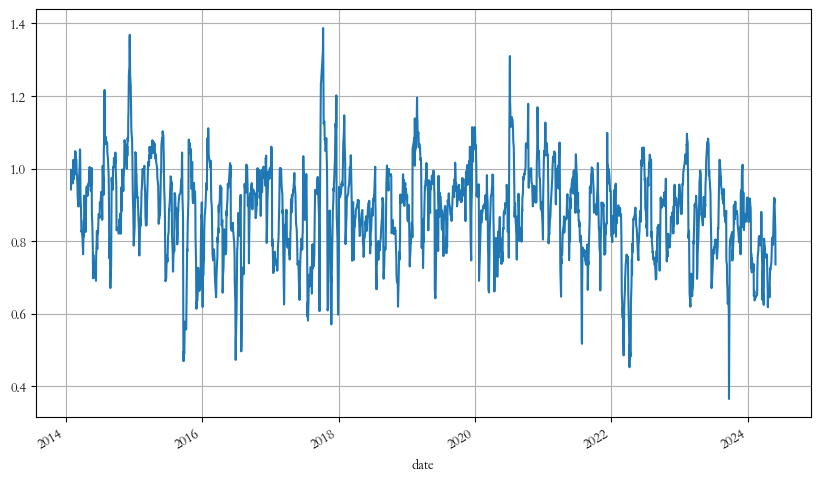

In [158]:
price_df['rsrs'].plot(figsize=(10, 6), grid=True)

In [159]:
# 计算择时信号
ratio = 0.14
timing_df = pd.DataFrame()
timing_df['rsrs'] = (price_df['rsrs'] >= 0.9+ratio) * 1. + (price_df['rsrs'] <= 0.9-ratio) * -1.
timing_df['rsrs'] = timing_df['rsrs'].replace(0, np.nan)
timing_df['rsrs'] = timing_df['rsrs'].fillna(method='ffill').fillna(0)
timing_df['rsrs'][timing_df['rsrs'] < 0] = 0
timing_df[f'ma_{days}'] = (price_df[[f'ma_{days}']].diff() > 0) * 1.
timing_df['不择时'] = 1.
timing_df

,rsrs,ma_20,不择时
date,,,
2014-01-29,0.0,0.0,1.0
2014-01-30,0.0,0.0,1.0
2014-02-07,0.0,0.0,1.0
2014-02-10,0.0,1.0,1.0
2014-02-11,0.0,1.0,1.0
...,...,...,...
2024-05-22,0.0,1.0,1.0
2024-05-23,0.0,1.0,1.0
2024-05-24,0.0,1.0,1.0


In [160]:
# 计算每日收益率
timing_ret = timing_df.mul(price_df['returns'], axis=0)
timing_ret['超额收益'] = (1 + timing_ret['rsrs']).div(1 + timing_ret['不择时'], axis=0) - 1.
cumul_ret = (1 + timing_ret.fillna(0)).cumprod() - 1.
cumul_ret

,rsrs,ma_20,不择时,超额收益
date,,,,
2014-01-29,0.000000,0.000000,-0.008211,0.008279
2014-01-30,0.000000,0.000000,-0.002643,0.002650
2014-02-07,0.000000,0.000000,0.017636,-0.017331
2014-02-10,0.000000,0.008439,0.026224,-0.025554
2014-02-11,0.000000,0.011451,0.029290,-0.028456
...,...,...,...,...
2024-05-22,1.495433,1.170681,0.520253,0.641459
2024-05-23,1.495433,1.151515,0.506830,0.656081
2024-05-24,1.495433,1.176013,0.523987,0.637437


<Axes: title={'center': 'RSRS择时'}, xlabel='date'>

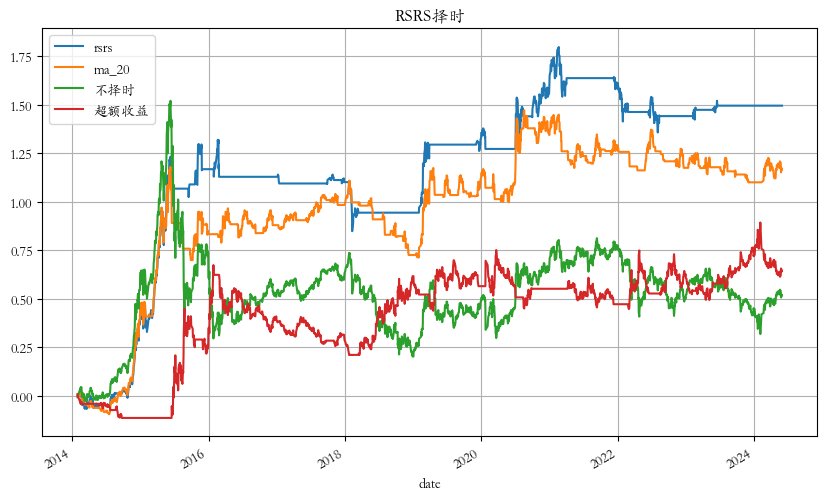

In [161]:
# 可视化输出
cumul_ret.plot(figsize=(10, 6), title='RSRS择时', grid=True)